<br/>
  <FONT size ="3pt"> MODAL APM 41M01 : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 1 : <center><b>Problème aux valeurs propres</b>  </center></FONT>

---
---
<br />

**<big><font color=black><span style="background-color:skyblue">Rendu attendu : Partie 1 et 2</span></font>**

In [ ]:
# importation de fonctions et de librairies
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve, qr

import numpy.random as npr
from tqdm import tqdm # barre de progression

Dans ce TP, on va étudier plusieurs méthodes numérique pour la recherche de valeurs propres et de vecteurs propres, c'est à dire pour une matrice $A\in\mathbb{R}^{N\times N}$, on cherche un ou tous les $\lambda\in\mathbb{R}$ et $V\in\mathbb{R}^N$ tels que

$$AV = \lambda V.$$

On pourra dans un premier temps tester ces méthodes sur les matrices de la forme (pour différentes valeurs de $N$) :

In [ ]:
def Laplacien(N):
    #construit la matrice du Laplacien 1D
    return 2*np.eye(N) - np.diag(np.ones(N-1),1) - np.diag(np.ones(N-1),-1)

print("Laplacien(3) :\n", Laplacien(3))

Laplacien(3) :
 [[ 2. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  2.]]


On appliquera dans un second temps ces méthodes pour étudier les ondes émises par un tambour et on étudiera alors les valeurs propres du Laplacien 2D discrétisé.


On notera $\|V\| = \sqrt{V^T V}$ dans tout ce TP.  

# Méthode de la puissance
La méthode de la puissance consiste à multiplier itérativement un vecteur par la matrice $A$ afin de récupérer sa plus grande valeur propre. L'algorithme prend la forme
- **Initialisation** : Choix d'un vecteur $V^0\in\mathbb{R}^N$ de norme $\|V^0\| = 1$.
- **Itération** : Calculer $$W^{i+1} = A V^i, \qquad V^{i+1} = \frac{W^{i+1}}{ \|W^{i+1}\|}$$ jusqu'à convergence.

1.  
- En supposant que l'algorithme converge vers une solution  
  $V^{\infty} = \frac{A V^\infty}{ \|A V^\infty\|}$, comment obtenir la valeur propre associée ?  

  Dans un tel cas,  
  $$\lambda = \|A V^\infty\|.$$

- Proposer un critère d'arrêt permettant de déterminer si l'on est proche ou non de la convergence.  

  Comme critère d'arrêt possible on peut s'arrêter lorsque :
  - $i >= N_{max}$, pour un certain $N_{max}$, fixé à l'avance (convergence non atteinte)
  
    ou
  - $\|V^{i+1} - V^i\| <= tol, \quad tol > 0$; pour une tolérance donnée

    Ou encore lorsque $$\||W^{i+1} - \lambda_i V^i\|| <= tol \text{, } \lambda_i = \||W^{i+1}\||$$

2. Implémenter cet algorithme, avec le critère d'arrêt proposé, et le tester avec la matrice du Laplacien $L\in\mathbb{R}^{N\times N}$ pour $N = 10$, puis pour $N=50$, avec un paramêtre de tolérance de $10^{-3}$ puis de $10^{-12}$.

In [ ]:
def puissance(A, V, N_max=1000, TOL=pow(10, -12)):
    """
    Calcule la plus grande valeur propre et le vecteur propre associé d'une matrice A par la méthode de la puissance.

    Paramètres :
        - A     : matrice (numpy array)
        - V     : vecteur initial (numpy array)
        - N_max : nombre maximum d'itérations (int)
        - TOL   : tolérance pour le critère d'arrêt (float)

    Retourne :
        - lamb : Valeur propre approchée à la fin des itérations (float)
        - V  : Vecteur propre associé (normalisé) (numpy array)
        - errors  : Vecteur contenant l'erreur à chaque itération pour étudier la convergence (numpy array)
    """

    errors = np.empty(N_max) # Initialisation du tableau pour stocker les erreurs

    for i in tqdm(range(N_max)): # Boucle d'itération avec barre de progression
        W = A @ V
        lamb = np.linalg.norm(W) # Estimation de la valeur propre
        error = np.linalg.norm(W - lamb * V)
        errors[i] = error
        if error <= TOL:
            print(" Convergence atteinte après {} itérations".format(i))
            return lamb, V, errors[:i+1]

        V = W / lamb # Normalisation du vecteur

    print(" Convergence non atteinte après {} itérations".format(N_max))
    return lamb, V, errors

In [ ]:
N = 10
N_max = 1000
TOL = pow(10, -12)
L = Laplacien(N)
npr.seed(0)
V0 = npr.randn(N, 1)
# print("Vecteur initial :\n", V, "\n")

lamb1, V, errors = puissance(L, V0, N_max=N_max, TOL=TOL)
print("Valeur propre obtenue :\n", lamb1, "\n")
print("Vecteur propre associé :\n", V, "\n")

 39%|███▉      | 393/1000 [00:00<00:00, 43138.40it/s]

 Convergence atteinte après 393 itérations
Valeur propre obtenue :
 3.9189859472289945 

Vecteur propre associé :
 [[ 0.12013117]
 [-0.23053002]
 [ 0.3222527 ]
 [-0.38786839]
 [ 0.42206128]
 [-0.42206128]
 [ 0.38786839]
 [-0.3222527 ]
 [ 0.23053002]
 [-0.12013117]] 



3.  
- En supposant que $A$ est symétrique définie positive, montrer que l'algorithme converge et donner son taux de convergence.  

  Par le **théorème spectral**, il existe une base orthonormée $(u_1,\dots,u_N)$ de $\mathbb{R}^N$ composée de vecteurs propres de $A$, associée à des valeurs propres $0<\lambda_N\le\dots\le\lambda_2<\lambda_1$, et $A=\sum_{j=1}^N \lambda_j\,u_j u_j^\top$.  
  Écrivons $V^0=\sum_{j=1}^N c_j u_j$ avec $c_1\neq 0$ (sinon un très léger bruit sur $V^0$ suffit). Alors, pour l’itéré non normalisé $Y^k:=A^k V^0$, on a $Y^k=\sum_{j=1}^N c_j \lambda_j^k u_j$; l’itéré normalisé vaut
  $$V^k=\frac{Y^k}{\|Y^k\|}=\frac{c_1\lambda_1^k u_1+\sum_{j\ge 2} c_j \lambda_j^k u_j}{\sqrt{c_1^2\lambda_1^{2k}+\sum_{j\ge 2} c_j^2\lambda_j^{2k}}}.$$
  Posons $\theta_k$ l’angle entre $V^k$ et $u_1$. Alors
  $$\tan\theta_k=\frac{\big\|(I-u_1u_1^\top)V^k\big\|}{|u_1^\top V^k|}
  =\frac{\sqrt{\sum_{j\ge 2} c_j^2(\lambda_j/\lambda_1)^{2k}}}{|c_1|}
  \le \frac{\sqrt{\sum_{j\ge 2} c_j^2}}{|c_1|}\left(\frac{\lambda_2}{\lambda_1}\right)^k.$$
  En particulier, $V^k\to \operatorname{sign}(c_1)\,u_1$ et la convergence est **géométrique** de raison $\lambda_2/\lambda_1$ (linéaire au sens des erreurs angulaires).  

  Ainsi, le taux de convergence est : $\lambda_2/\lambda_1$.  

- Montrer que le Laplacien discret est symétrique défini positif pour toute taille $N$ de matrice.  

  Pour le Laplacien 1D avec conditions de Dirichlet, la matrice $L\in\mathbb{R}^{N\times N}$ est tridiagonale avec $2$ sur la diagonale et $-1$ sur les sous/sur-diagonales; elle est symétrique car $L=L^\top$. Pour tout $x\in\mathbb{R}^N$, en posant $x_0=x_{N+1}=0$, on a
  $$x^\top L x=\sum_{i=0}^{N} (x_{i+1}-x_i)^2 \;\ge\; 0.$$
  L’égalité $x^\top L x=0$ implique $x_{i+1}-x_i=0$ pour tout $i$ et, avec $x_0=0$, donne $x\equiv 0$. Donc $L$ est **symétrique défini positif** pour tout $N$.


- Tracer les courbes de convergence avec la matrice *Laplacien(10)*.

- Évaluer numériquement le taux de convergence de l'algorithme.

-  Qu'en déduire sur la seconde valeur propre de cette matrice?

Text(0.5, 1.0, 'Convergence de la methode de la puissance')

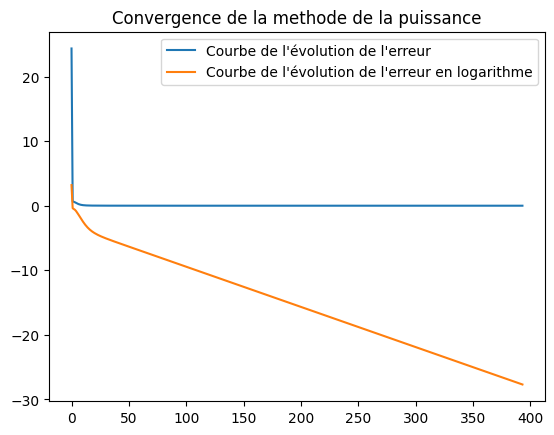

In [ ]:
# Tracés des cournes de convergence

errors_log = np.log(errors)
plt.plot(errors, label="Courbe de l'évolution de l'erreur")
plt.plot(errors_log, label="Courbe de l'évolution de l'erreur en logarithme")
plt.legend()
plt.title("Convergence de la methode de la puissance")

In [ ]:
def convergence_slope(errors_log):
    """
    Renvoie la pente de la courbe d'erreur en log
    ----------
    Paramètres :
        - errors_log : Vecteur contenant le logarithme del'erreur à chaque itération pour étudier la convergence

    Retourne :
        - slope : Pente de la courbe d'erreur en log
    """

    errors_log = errors_log[len(errors)//2:]  # on ne prend que la queue de la courbe, plus stable
    i = np.arange(len(errors_log))
    slope, _ = np.polyfit(i, errors_log, 1)
    return slope

In [ ]:
# Calcul de la pente de la courbe d'erreur en log pour estimer le taux de convergence

slope = convergence_slope(errors_log)
rate = np.exp(slope)
lamb2 = lamb1 * rate
print(f"La pente de la courbe log(erreur) est : {slope}")
print(f"Le taux de convergence numérique est donc : {rate}")
print(f"La 2è valeur propre est : {lamb2}")

La pente de la courbe log(erreur) est : -0.062239172447604164
Le taux de convergence numérique est donc : 0.9396581195807272
La 2è valeur propre est : 3.682506965836492


In [ ]:
# Vérification des 2 valeurs propres

lambs = np.sort(np.linalg.eigvals(L))[::-1]
print("Valeur propres :\n", lambs, "\n")
print("Les valeurs propres obtenues avec la méthode de la puissance sont respectivement :", lamb1, "et", lamb2)
print("Elles figurent bien dans la liste des valeurs propres de L")

Valeur propres :
 [3.91898595 3.68250707 3.30972147 2.83083003 2.28462968 1.71537032
 1.16916997 0.69027853 0.31749293 0.08101405] 

Les valeurs propres obtenues avec la méthode de la puissance sont respectivement : 3.9189859472289945 et 3.682506965836492
Elles figurent bien dans la liste des valeurs propres de L


In [ ]:
# Erreurs d'estimation des 2 valeurs propres obtenues par la methode de la puissance

error1 = np.abs(lamb1 - lambs[0])
error2 = np.abs(lamb2 - lambs[1])
print("L'erreur d'estimation de la 1ere valeur propre est de :", error1)
print("L'erreur d'estimation de la 2eme valeur propre est de :", error2)

L'erreur d'estimation de la 1ere valeur propre est de : 1.7763568394002505e-15
L'erreur d'estimation de la 2eme valeur propre est de : 9.982587156898148e-08


---

# Son d'un tambour

On peut relier la description des ondes accoustiques produites à la déformation périodique de l'objet qui l'a produit. Ces ondes de déformation sont généralement régies par l'équation des ondes

$$\partial_t^2 d - \Delta_x d = 0.$$

En faisant une hypothèse de séparation des variables $d(t,x) = H(t)D(x)$, on arrive à un problème aux valeurs propres suivant

$$ \text{Chercher $\lambda$ et $D(x)$ tels que $\Delta_x D = \lambda D$.} $$

En 1D, l'exemple type de la corde vibrante peut se résoudre analytiquement menant à une solution sinusoïdale dont la période dépend des conditions de bord.

On va s'intéresser ici au cas 2D discret et chercher à tracer les courbes de Chladni, isocontours de la fonction $D(x)$.

On définit le Laplacien discret en 2D comme

$$\Delta_x D(x_{i,j}) \approx (L D)_{i,j} = \frac{1}{\Delta x^2} \left(-D_{i+1,j}+2D_{i,j}-D_{i-1,j}\right) + \frac{1}{\Delta y^2} \left(-D_{i,j+1}+2D_{i,j}-D_{i,j-1}\right),$$

où $D_{i,j} \approx D(x_{i,j})$ et la matrice $L$ est le Laplacien discrétisé qui correspond au niveau discret à l'opérateur continu $\Delta_x$. On cherche désormais à résoudre $L D = \lambda D$.

Pour le moment, on imposera des conditions de bord de type Dirichlet $D(0,y) = 0 = D(1,y) = D(x,0) = D(x,1).$


1.  
- On réécrit la matrice $(D_{i,j})_{i=1,\dots,N_x,\ j=1,\dots,N_y}$ sous la forme d’un vecteur $(\tilde D_l)_{l=1,\dots,N_xN_y}$.  
  Avec un parcours par lignes, on pose $l(i,j)=(i-1)N_y+j$ (et donc $i(l)=1+\left\lfloor\frac{l-1}{N_y}\right\rfloor$, $j(l)=1+((l-1)\bmod N_y)$), de sorte que $\tilde D_{\,l(i,j)}=D_{i,j}$.

- On part de la définition locale du Laplacien 5-points avec Dirichlet ($D_{0,j}=D_{N_x+1,j}=D_{i,0}=D_{i,N_y+1}=0$). On fixe pour simplifier $\Delta_x = \Delta_y$ et on multiplie par l'équation par $Δ_x$.

  Pour chaque $(i,j)$,
  $$ (L D)_{i,j}=4D_{i,j}-D_{i+1,j}-D_{i-1,j}-D_{i,j+1}-D_{i,j-1}. $$

  On isole les contributions selon $i$ et selon $j$ en introduisant les matrices tridiagonales de Dirichlet $T_x\in\mathbb{R}^{N_x\times N_x}$ et $T_y\in\mathbb{R}^{N_y\times N_y}$ (diagonale $2$, sous/sur-diagonales $-1$). Pour tout $(i,j)$,
  $$ (T_x D)_{i,j}=\sum_{p=1}^{N_x}(T_x)_{i,p}D_{p,j}=2D_{i,j}-D_{i+1,j}-D_{i-1,j}, $$
  $$ (D T_y)_{i,j}=\sum_{q=1}^{N_y}D_{i,q}(T_y)_{q,j}=2D_{i,j}-D_{i,j+1}-D_{i,j-1}. $$
  Par addition terme à terme, on retrouve $L$ indépendamment de toute vectorisation :
  $$ (L D)_{i,j}=(T_x D)_{i,j}+(D T_y)_{i,j}. $$

  On passe ensuite à l’écriture vectorielle en remplaçant $D_{p,q}$ par $\tilde D_{\,l(p,q)}$. Le choix $l(i,j)=(i-1)N_y+j$ entraîne, pour chaque $(i,j)$,
  $$ (\tilde L\tilde D)_{\,l(i,j)}=\sum_{p=1}^{N_x}(T_x)_{i,p}\,\tilde D_{\,l(p,j)}+\sum_{q=1}^{N_y}(T_y)_{j,q}\,\tilde D_{\,l(i,q)}. $$
  Cette forme impose une matrice $\tilde L$ qui agit par blocs identité sur l’indice $j$ pour la première somme et par blocs identité sur l’indice $i$ pour la seconde. On en déduit l’expression compacte
  $$ \tilde L = T_{x}\otimes I_{N_y} \;+\; I_{N_x}\otimes T_{y}, $$
  et, dans le cas isotrope $N_x=N_y=N$ avec $T_x=T_y=T$,
  $$ \tilde L = T\otimes I \;+\; I\otimes T. $$

In [ ]:
def Laplacien_2D_Dirichlet(N):
    """
    Renvoie la matrice (carrée) du Laplacien 2D avec des conditions de Dirichlet au bord.

    Paramètres :
        - N : nombre de pas d'espace dans une direction (int)

    Retourne :
        - L : matrice du Laplacien 2D sur un carré (numpy array)
    """

    T = (2 * np.eye(N, dtype=int) # Diagonale principale avec 2
         - np.eye(N, k=1, dtype=int) # Sous-diagonale avec -1
         - np.eye(N, k=-1, dtype=int)) # Sur-diagonale avec -1
    I = np.eye(N, dtype=int)

    # Utilisation du produit de Kronecker pour construire la matrice du Laplacien 2D
    # np.kron(I, T) correspond au Laplacien agissant sur les indices de colonne
    # np.kron(T, I) correspond au Laplacien agissant sur les indices de ligne
    return np.kron(I, T) + np.kron(T, I)

print("Laplacien 2D(3) :\n", Laplacien_2D_Dirichlet(3))

Laplacien 2D(3) :
 [[ 4 -1  0 -1  0  0  0  0  0]
 [-1  4 -1  0 -1  0  0  0  0]
 [ 0 -1  4  0  0 -1  0  0  0]
 [-1  0  0  4 -1  0 -1  0  0]
 [ 0 -1  0 -1  4 -1  0 -1  0]
 [ 0  0 -1  0 -1  4  0  0 -1]
 [ 0  0  0 -1  0  0  4 -1  0]
 [ 0  0  0  0 -1  0 -1  4 -1]
 [ 0  0  0  0  0 -1  0 -1  4]]


2. - Calculer la 1e valeur propre du Laplacien pour différentes valeurs de $N$.
   - Tracer les isocontours de $D$.
  
*Le contour de déplacement $D=0$ correspond aux positions qui ne sont pas déplacées par cette oscillation.*

In [ ]:
# Cas test du Laplacien 2D
N2 = 30
NN = N2 * N2
L2 = Laplacien_2D_Dirichlet(N2)

# Vecteur initial
npr.seed(0)
D0 = npr.randn(N2, N2)
# D0[0, :] = 0
# D0[N-1, :] = 0
# D0[:, 0] = 0
# D0[:, N-1] = 0
D0_vect = D0.reshape((NN, 1))

eig_val1, D_vect1, errors = puissance(L2, D0_vect, N_max=2000, TOL=pow(10, -4))

print("Valeur propre obtenue :\n", eig_val1, "\n")
print("Il s'agit de celle numérique après avoir mumtiplié l'équation par Δx^2. En effet celle physique vaut lambda / Δx^2\n")
print("Erreur finale :\n", errors[-1])

 60%|█████▉    | 1194/2000 [00:01<00:01, 690.90it/s]

 Convergence atteinte après 1194 itérations
Valeur propre obtenue :
 7.979476968982749 

Il s'agit de celle numérique après avoir mumtiplié l'équation par Δx^2. En effet celle physique vaut lambda / Δx^2

Erreur finale :
 9.988758887173408e-05


Text(0.5, 1.0, "Courbe de l'évolution du logarithme l'erreur")

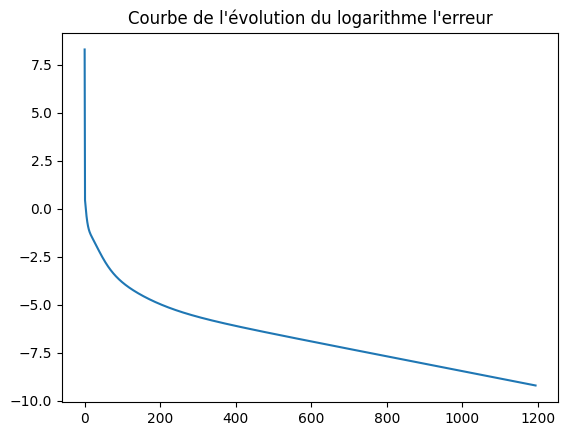

In [ ]:
plt.plot(np.log(errors))
plt.title("Courbe de l'évolution du logarithme l'erreur")

Text(0, 0.5, 'y index')

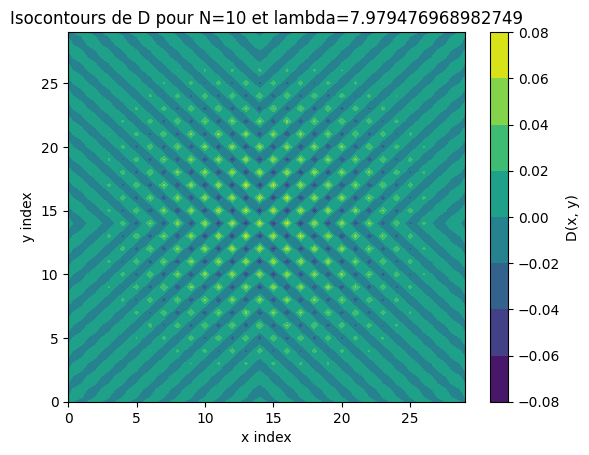

In [ ]:
# courbe de contour de D en 2D

D1 = D_vect1.reshape(N2, N2)

# Tracé des isocontours
plt.contourf(D1)
plt.colorbar(label='D(x, y)')
plt.title(f'Isocontours de D pour N={N} et lambda={eig_val1}')
plt.xlabel('x index')
plt.ylabel('y index')

**<big><font color=black><span style="background-color:skyblue">Rendu attendu: jusqu'ici</span></font>**

# D'autres méthodes de puissance
On veut maintenant aller plus loin et calculer d'autres valeurs propres et vecteurs propres.

## Méthode de la puissance inverse
Soit $\mu\in\mathbb{R}$ une première estimation d'une valeur propre $\lambda$ de $A$ (qui peut ou non être $\lambda_1$).

1. On suppose que $0 < |\mu-\lambda| < |\mu-\lambda_i|$ pour toute autre valeur propre $\lambda_i\neq \lambda$. Comment peut on relier la plus grande valeur propre de $(A-\mu Id)^{-1}$ à $\lambda$? Comment relier les vecteurs propres associés?

   Pour chaque paire propre $(\lambda_i,v_i)$ de $A$ avec $A v_i=\lambda_i v_i$ et $\mu\neq\lambda_i$, on a, par simple translation puis inversion,
   $$ (A-\mu Id)\,v_i=(\lambda_i-\mu)\,v_i \quad\Rightarrow\quad (A-\mu Id)^{-1}v_i=\frac{1}{\lambda_i-\mu}\,v_i. $$
   Ainsi, les **vecteurs propres** de $(A-\mu Id)^{-1}$ sont exactement ceux de $A$, et les **valeurs propres** sont l’image des $\lambda_i$ par la transformation $\lambda\mapsto\frac{1}{\lambda-\mu}$.

   Sous l’hypothèse $0<|\mu-\lambda|<|\mu-\lambda_i|$ pour tout $i\neq$ l’indice de $\lambda$, on obtient pour les modules
   $$ \left|\frac{1}{\lambda-\mu}\right| \;>\; \left|\frac{1}{\lambda_i-\mu}\right|\quad\text{pour tout }\lambda_i\neq \lambda, $$
   puisque la fonction $x\mapsto 1/|x|$ est strictement décroissante sur $(0,+\infty)$ et que $|\lambda-\mu|$ est la **distance minimale** de $\mu$ au spectre de $A$.

   On en déduit que la **plus grande valeur propre en module** (rayon spectral) de $(A-\mu Id)^{-1}$ est
   $$ \rho\big((A-\mu Id)^{-1}\big)=\max_i\left|\frac{1}{\lambda_i-\mu}\right|=\left|\frac{1}{\lambda-\mu}\right|, $$
   et l’**espace propre dominant** de $(A-\mu Id)^{-1}$ est exactement l’espace propre de $A$ associé à $\lambda$ (mêmes vecteurs propres).

   En particulier, si $A$ est diagonalisable (par exemple symétrique réelle), l’itération de puissance appliquée à $(A-\mu Id)^{-1}$ converge, pour toute condition initiale ayant une composante non nulle, vers le vecteur propre $v$ de $A$ associé à $\lambda$. Une fois $v$ trouvé, on déduit $\lambda$ par la relation : $$\lambda = \frac{1}{v} + \mu$$


2. Utiliser la méthode de la puissance sur $(A-\mu Id)^{-1}$ pour calculer $\lambda$ pour la matrice $L$ avec $N=10$ pour un $\mu$ choisi.

*Indications :* Le calcul de l'inverse $(A-\mu Id)^{-1}$ est également complexe dans le cas général et nécessite un algorithme en lui même. Ici, on pourra utiliser une décomposition LU. Cette décomposition consiste à décomposer $A=LU$ comme le produit d'une matrice triangulaire inférieur L et une matrice triangulaire supérieur U. Cette décomposition est codée dans la fonction lu_factor de scipy. Une fois cette décomposition obtenue, on peut facilement calculer la solution $b = U^{-1}L^{-1} V$ du problème $AV = b$. Cette solution est le résultat de la fonction LU_solve de scipy.

3. Comparer la vitesse de convergence de cet algorithme pour différentes valeurs de $\mu$ proche de $\lambda_1$ (tracer le sur un intervale de $\mu$ adapté). On pourra utiliser la valeur de $\lambda_1$ trouvée à la section précédente.

4. - Utiliser la méthode de la puissance pour calculer d'autres valeurs propres et vecteurs propres du Laplacien 2D.
   - Tracer les figures de Chaldni de ces harmoniques.

In [ ]:
def puissance_inverse(A, V, mu, N_max=1000, TOL=pow(10, -12)):
    """
    Renvoie une valeur propre approchée de A par la méthode de la puissance inverse
    ----------
    Paramètres :
        - A     : matrice
        - V     : vecteur initial
        - mu    : paramètre de la méthode
        - N_max : nombre maximum d'itérations
        - TOL   : tolérance pour le critère d'arrêt

    Retourne :
        - lamb : Valeur propre approchée à la fin des itérations
        - V  : Vecteur propre associé
        - errors  : Vecteur contenant l'erreur à chaque itération pour étudier la convergence
    """

    I = np.eye(A.shape[0])
    A_ = A - mu * I
    lu, piv = lu_factor(A_)
    A_1 = lu_solve((lu, piv), I) # Inverse de A - mu * I
    lamb, V, errors = puissance(A_1, V, N_max=N_max, TOL=TOL)
    return 1 / lamb + mu, V, errors

In [ ]:
# 2.b Proposer un/des cas test (matrice, vecteur initiale...) pour tester votre algorithme
print("Valeur propre 1 :\n", lamb1, "\n")

mu = 0
lamb, V, errors = puissance_inverse(L, V0, mu)

print("Valeur propre obtenue :\n", lamb, "\n")
print("Erreur finale :\n", errors[-1])

Valeur propre 1 :
 3.9189859472289945 



  2%|▏         | 22/1000 [00:00<00:00, 30403.52it/s]

 Convergence atteinte après 22 itérations
Valeur propre obtenue :
 0.08101405277100522 

Erreur finale :
 6.459759564613194e-13


  2%|▏         | 22/1000 [00:00<00:00, 10591.68it/s]


 Convergence atteinte après 22 itérations


  2%|▏         | 16/1000 [00:00<00:00, 16578.28it/s]


 Convergence atteinte après 16 itérations


  1%|          | 6/1000 [00:00<00:00, 10833.33it/s]


 Convergence atteinte après 6 itérations


100%|██████████| 1000/1000 [00:00<00:00, 11350.04it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 21634.51it/s]


 Convergence non atteinte après 1000 itérations


 66%|██████▌   | 656/1000 [00:00<00:00, 48292.47it/s]


 Convergence atteinte après 656 itérations


  4%|▍         | 41/1000 [00:00<00:00, 32836.83it/s]


 Convergence atteinte après 41 itérations


  2%|▏         | 18/1000 [00:00<00:00, 21908.73it/s]


 Convergence atteinte après 18 itérations


100%|██████████| 1000/1000 [00:00<00:00, 45374.73it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 40694.93it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 41448.97it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 33025.50it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 30149.04it/s]


 Convergence non atteinte après 1000 itérations


 14%|█▍        | 139/1000 [00:00<00:00, 15230.50it/s]

 Convergence atteinte après 139 itérations



  5%|▍         | 47/1000 [00:00<00:00, 26773.37it/s]

 Convergence atteinte après 47 itérations



  3%|▎         | 27/1000 [00:00<00:00, 13979.29it/s]


 Convergence atteinte après 27 itérations


  2%|▏         | 17/1000 [00:00<00:00, 20953.03it/s]


 Convergence atteinte après 17 itérations


  1%|          | 8/1000 [00:00<00:00, 10706.58it/s]


 Convergence atteinte après 8 itérations


100%|██████████| 1000/1000 [00:00<00:00, 13085.28it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 12024.61it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 19702.58it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 18194.34it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 37169.05it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 37487.30it/s]


 Convergence non atteinte après 1000 itérations


  9%|▊         | 86/1000 [00:00<00:00, 26548.18it/s]


 Convergence atteinte après 86 itérations


  4%|▍         | 42/1000 [00:00<00:00, 25044.18it/s]


 Convergence atteinte après 42 itérations


  3%|▎         | 27/1000 [00:00<00:00, 11125.47it/s]


 Convergence atteinte après 27 itérations


  2%|▏         | 19/1000 [00:00<00:00, 22105.90it/s]


 Convergence atteinte après 19 itérations


  1%|▏         | 13/1000 [00:00<00:00, 11539.88it/s]


 Convergence atteinte après 13 itérations


100%|██████████| 1000/1000 [00:00<00:00, 37253.23it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 23900.67it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 29637.74it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 34862.76it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 22357.58it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17549.39it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17335.06it/s]


 Convergence non atteinte après 1000 itérations


 34%|███▍      | 344/1000 [00:00<00:00, 12451.59it/s]


 Convergence atteinte après 344 itérations


  8%|▊         | 80/1000 [00:00<00:00, 12612.55it/s]


 Convergence atteinte après 80 itérations


  4%|▍         | 44/1000 [00:00<00:00, 9681.02it/s]


 Convergence atteinte après 44 itérations


  3%|▎         | 30/1000 [00:00<00:00, 14211.56it/s]


 Convergence atteinte après 30 itérations


  2%|▏         | 21/1000 [00:00<00:00, 8323.60it/s]


 Convergence atteinte après 21 itérations


  0%|          | 0/1000 [00:00<?, ?it/s]

 Convergence atteinte après 16 itérations


  1%|          | 10/1000 [00:00<00:00, 14593.96it/s]


 Convergence atteinte après 10 itérations


100%|██████████| 1000/1000 [00:00<00:00, 6883.98it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 15188.39it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 16592.97it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 13667.66it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17655.17it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 13090.10it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 18487.62it/s]


 Convergence non atteinte après 1000 itérations


 20%|█▉        | 195/1000 [00:00<00:00, 19093.50it/s]


 Convergence atteinte après 195 itérations


  6%|▋         | 65/1000 [00:00<00:00, 14743.92it/s]

 Convergence atteinte après 65 itérations



  4%|▍         | 38/1000 [00:00<00:00, 8455.36it/s]


 Convergence atteinte après 38 itérations


  3%|▎         | 26/1000 [00:00<00:00, 26986.37it/s]


 Convergence atteinte après 26 itérations


  2%|▏         | 19/1000 [00:00<00:00, 3739.64it/s]


 Convergence atteinte après 19 itérations


  1%|▏         | 14/1000 [00:00<00:00, 22166.95it/s]


 Convergence atteinte après 14 itérations


  1%|          | 10/1000 [00:00<00:00, 8674.88it/s]


 Convergence atteinte après 10 itérations


100%|██████████| 1000/1000 [00:00<00:00, 18561.82it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17342.87it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 21338.98it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17402.45it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 8861.06it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 8184.36it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 19409.09it/s]


 Convergence non atteinte après 1000 itérations


 14%|█▍        | 142/1000 [00:00<00:00, 14319.16it/s]


 Convergence atteinte après 142 itérations


  6%|▌         | 58/1000 [00:00<00:00, 3918.33it/s]


 Convergence atteinte après 58 itérations


  4%|▎         | 35/1000 [00:00<00:00, 5504.54it/s]


 Convergence atteinte après 35 itérations


  0%|          | 0/1000 [00:00<?, ?it/s]

 Convergence atteinte après 25 itérations

  2%|▎         | 25/1000 [00:00<00:00, 3651.41it/s]


  2%|▏         | 18/1000 [00:00<00:00, 6278.38it/s]


 Convergence atteinte après 18 itérations


  1%|▏         | 13/1000 [00:00<00:00, 10691.36it/s]

 Convergence atteinte après 13 itérations



  0%|          | 0/1000 [00:00<?, ?it/s]

 Convergence atteinte après 7 itérations


100%|██████████| 1000/1000 [00:00<00:00, 14602.04it/s]

 Convergence non atteinte après 1000 itérations



100%|██████████| 1000/1000 [00:00<00:00, 16652.98it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 14979.55it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 15547.65it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 16024.39it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 14008.05it/s]


 Convergence non atteinte après 1000 itérations


  9%|▉         | 91/1000 [00:00<00:00, 12873.77it/s]


 Convergence atteinte après 91 itérations


  4%|▍         | 45/1000 [00:00<00:00, 26327.76it/s]


 Convergence atteinte après 45 itérations


  3%|▎         | 29/1000 [00:00<00:00, 29944.56it/s]


 Convergence atteinte après 29 itérations


  2%|▏         | 20/1000 [00:00<00:00, 4201.87it/s]


 Convergence atteinte après 20 itérations


  0%|          | 0/1000 [00:00<?, ?it/s]

 Convergence atteinte après 14 itérations

  1%|▏         | 14/1000 [00:00<00:00, 2821.05it/s]


100%|██████████| 1000/1000 [00:00<00:00, 13121.80it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 25306.83it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 17444.14it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 19067.10it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 10217.50it/s]


 Convergence non atteinte après 1000 itérations


 15%|█▌        | 151/1000 [00:00<00:00, 6616.17it/s]


 Convergence atteinte après 151 itérations


  5%|▍         | 47/1000 [00:00<00:00, 6284.50it/s]


 Convergence atteinte après 47 itérations


  3%|▎         | 27/1000 [00:00<00:00, 9657.70it/s]


 Convergence atteinte après 27 itérations


  2%|▏         | 18/1000 [00:00<00:00, 4273.12it/s]


 Convergence atteinte après 18 itérations


  1%|          | 10/1000 [00:00<00:00, 3082.23it/s]


 Convergence atteinte après 10 itérations


100%|██████████| 1000/1000 [00:00<00:00, 11913.74it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 19196.34it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 10414.60it/s]


 Convergence non atteinte après 1000 itérations


  4%|▍         | 44/1000 [00:00<00:00, 24982.99it/s]


 Convergence atteinte après 44 itérations


  2%|▏         | 19/1000 [00:00<00:00, 29515.47it/s]


 Convergence atteinte après 19 itérations


100%|██████████| 1000/1000 [00:00<00:00, 14986.03it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 12989.00it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 13729.26it/s]


 Convergence non atteinte après 1000 itérations


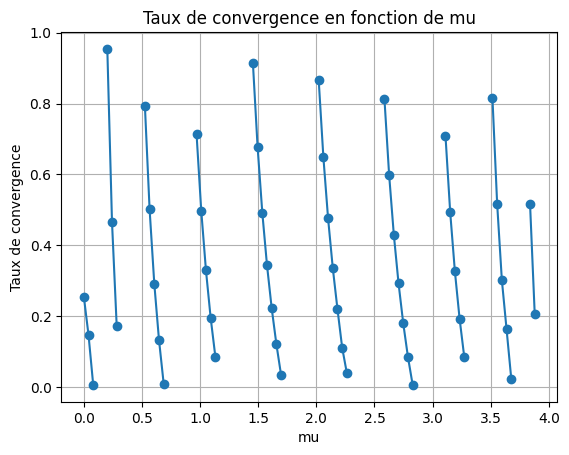

In [ ]:
# 3. Comparaison des taux de convergence en fonction de mu

mu_interval = np.linspace(0, 4, 100)
l = len(mu_interval)
conv_speeds = np.empty(l)

for i, mu in enumerate(mu_interval):
    _, _, errors = puissance_inverse(L, V0, mu) # On ne prend que les erreur
    if len(errors) < N_max: # Il y a eu convergence
        conv_speeds[i] = np.exp(convergence_slope(np.log(errors))) # On estime le taux de convergence
    else:
        conv_speeds[i] = np.nan # Pas de convergence

plt.plot(mu_interval, conv_speeds, '-o')
plt.xlabel("mu")
plt.ylabel("Taux de convergence")
plt.title("Taux de convergence en fonction de mu")
plt.grid(True)

Les points en fin de décroissance des courbes obtenues nous indiquent d'autres valeurs propres

In [ ]:
# 4. Cas test du Laplacien 2D

print("Valeur propre 1 :\n", eig_val1, "\n")

# Determination d'autres valeurs propres & vecteurs propres
mu_interval = np.linspace(0, 8.2, 30)
l = len(mu_interval)

eig_vals = np.empty(l)
eig_vals[-1] = eig_val1
eig_vects = np.empty((l, NN, 1))
eig_vects[-1] = D_vect1

for i, mu in enumerate(mu_interval[:-1]):
    eig_val, eig_vect, errors = puissance_inverse(L2, D0_vect, mu, N_max=1000, TOL=pow(10, -4))
    if errors[-1] <= 1e-3: # Il y a eu convergence
        eig_vals[i] = eig_val
        eig_vects[i] = eig_vect
    else: # Pas de convergence
        eig_vals[i] = np.nan
        eig_vects[i] = np.nan

# Retrait des valeurs propres non trouvées
valid_indices = ~np.isnan(eig_vals) # On trouve les indices des valeurs propres valides
eig_vals = eig_vals[valid_indices]
eig_vects = eig_vects[valid_indices]


print("Valeurs propres obtenues :\n", eig_vals, "\n")

Valeur propre 1 :
 7.979476968982749 



  1%|▏         | 13/1000 [00:00<00:01, 982.31it/s]

 Convergence atteinte après 13 itérations



  2%|▏         | 19/1000 [00:00<00:06, 144.30it/s]


 Convergence atteinte après 19 itérations


  1%|          | 10/1000 [00:00<00:00, 1330.43it/s]


 Convergence atteinte après 10 itérations


100%|██████████| 1000/1000 [00:02<00:00, 372.88it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:01<00:00, 546.58it/s]


 Convergence non atteinte après 1000 itérations


  4%|▍         | 38/1000 [00:00<00:03, 295.44it/s]


 Convergence atteinte après 38 itérations


  2%|▏         | 18/1000 [00:00<00:00, 2233.19it/s]


 Convergence atteinte après 18 itérations


  1%|          | 9/1000 [00:00<00:00, 1995.39it/s]


 Convergence atteinte après 9 itérations


  1%|▏         | 13/1000 [00:00<00:00, 2039.88it/s]


 Convergence atteinte après 13 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2406.18it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2275.36it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2582.05it/s]


 Convergence non atteinte après 1000 itérations


  1%|▏         | 14/1000 [00:00<00:00, 2419.16it/s]


 Convergence atteinte après 14 itérations


 12%|█▏        | 122/1000 [00:00<00:00, 1552.72it/s]


 Convergence atteinte après 122 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2527.23it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:01<00:00, 886.36it/s]


 Convergence non atteinte après 1000 itérations


  1%|          | 6/1000 [00:00<00:02, 487.73it/s]


 Convergence atteinte après 6 itérations


100%|██████████| 1000/1000 [00:02<00:00, 423.23it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2822.16it/s]


 Convergence non atteinte après 1000 itérations


  8%|▊         | 80/1000 [00:00<00:00, 1578.11it/s]


 Convergence atteinte après 80 itérations


  1%|          | 9/1000 [00:00<00:00, 1496.78it/s]

 Convergence atteinte après 9 itérations



  3%|▎         | 30/1000 [00:00<00:00, 1900.74it/s]


 Convergence atteinte après 30 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2344.47it/s]


 Convergence non atteinte après 1000 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2226.00it/s]


 Convergence non atteinte après 1000 itérations


  1%|          | 8/1000 [00:00<00:00, 2010.45it/s]


 Convergence atteinte après 8 itérations


100%|██████████| 1000/1000 [00:00<00:00, 2325.26it/s]


 Convergence non atteinte après 1000 itérations


  1%|          | 11/1000 [00:00<00:00, 1289.83it/s]

 Convergence atteinte après 11 itérations



100%|██████████| 1000/1000 [00:00<00:00, 2406.76it/s]


 Convergence non atteinte après 1000 itérations


  1%|          | 6/1000 [00:00<00:02, 388.89it/s]

 Convergence atteinte après 6 itérations
Valeurs propres obtenues :
 [0.02052271 0.29224689 0.57420524 1.42455573 1.7074058  1.98117869
 2.26338271 3.39428889 3.67960062 4.52448127 5.38209337 5.65620433
 5.93871632 6.78906682 7.35543187 7.91811977 7.97947697] 



<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-633161058.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f'$\lambda$={eig_val:.4f}')


Tracé des figures de Chladni


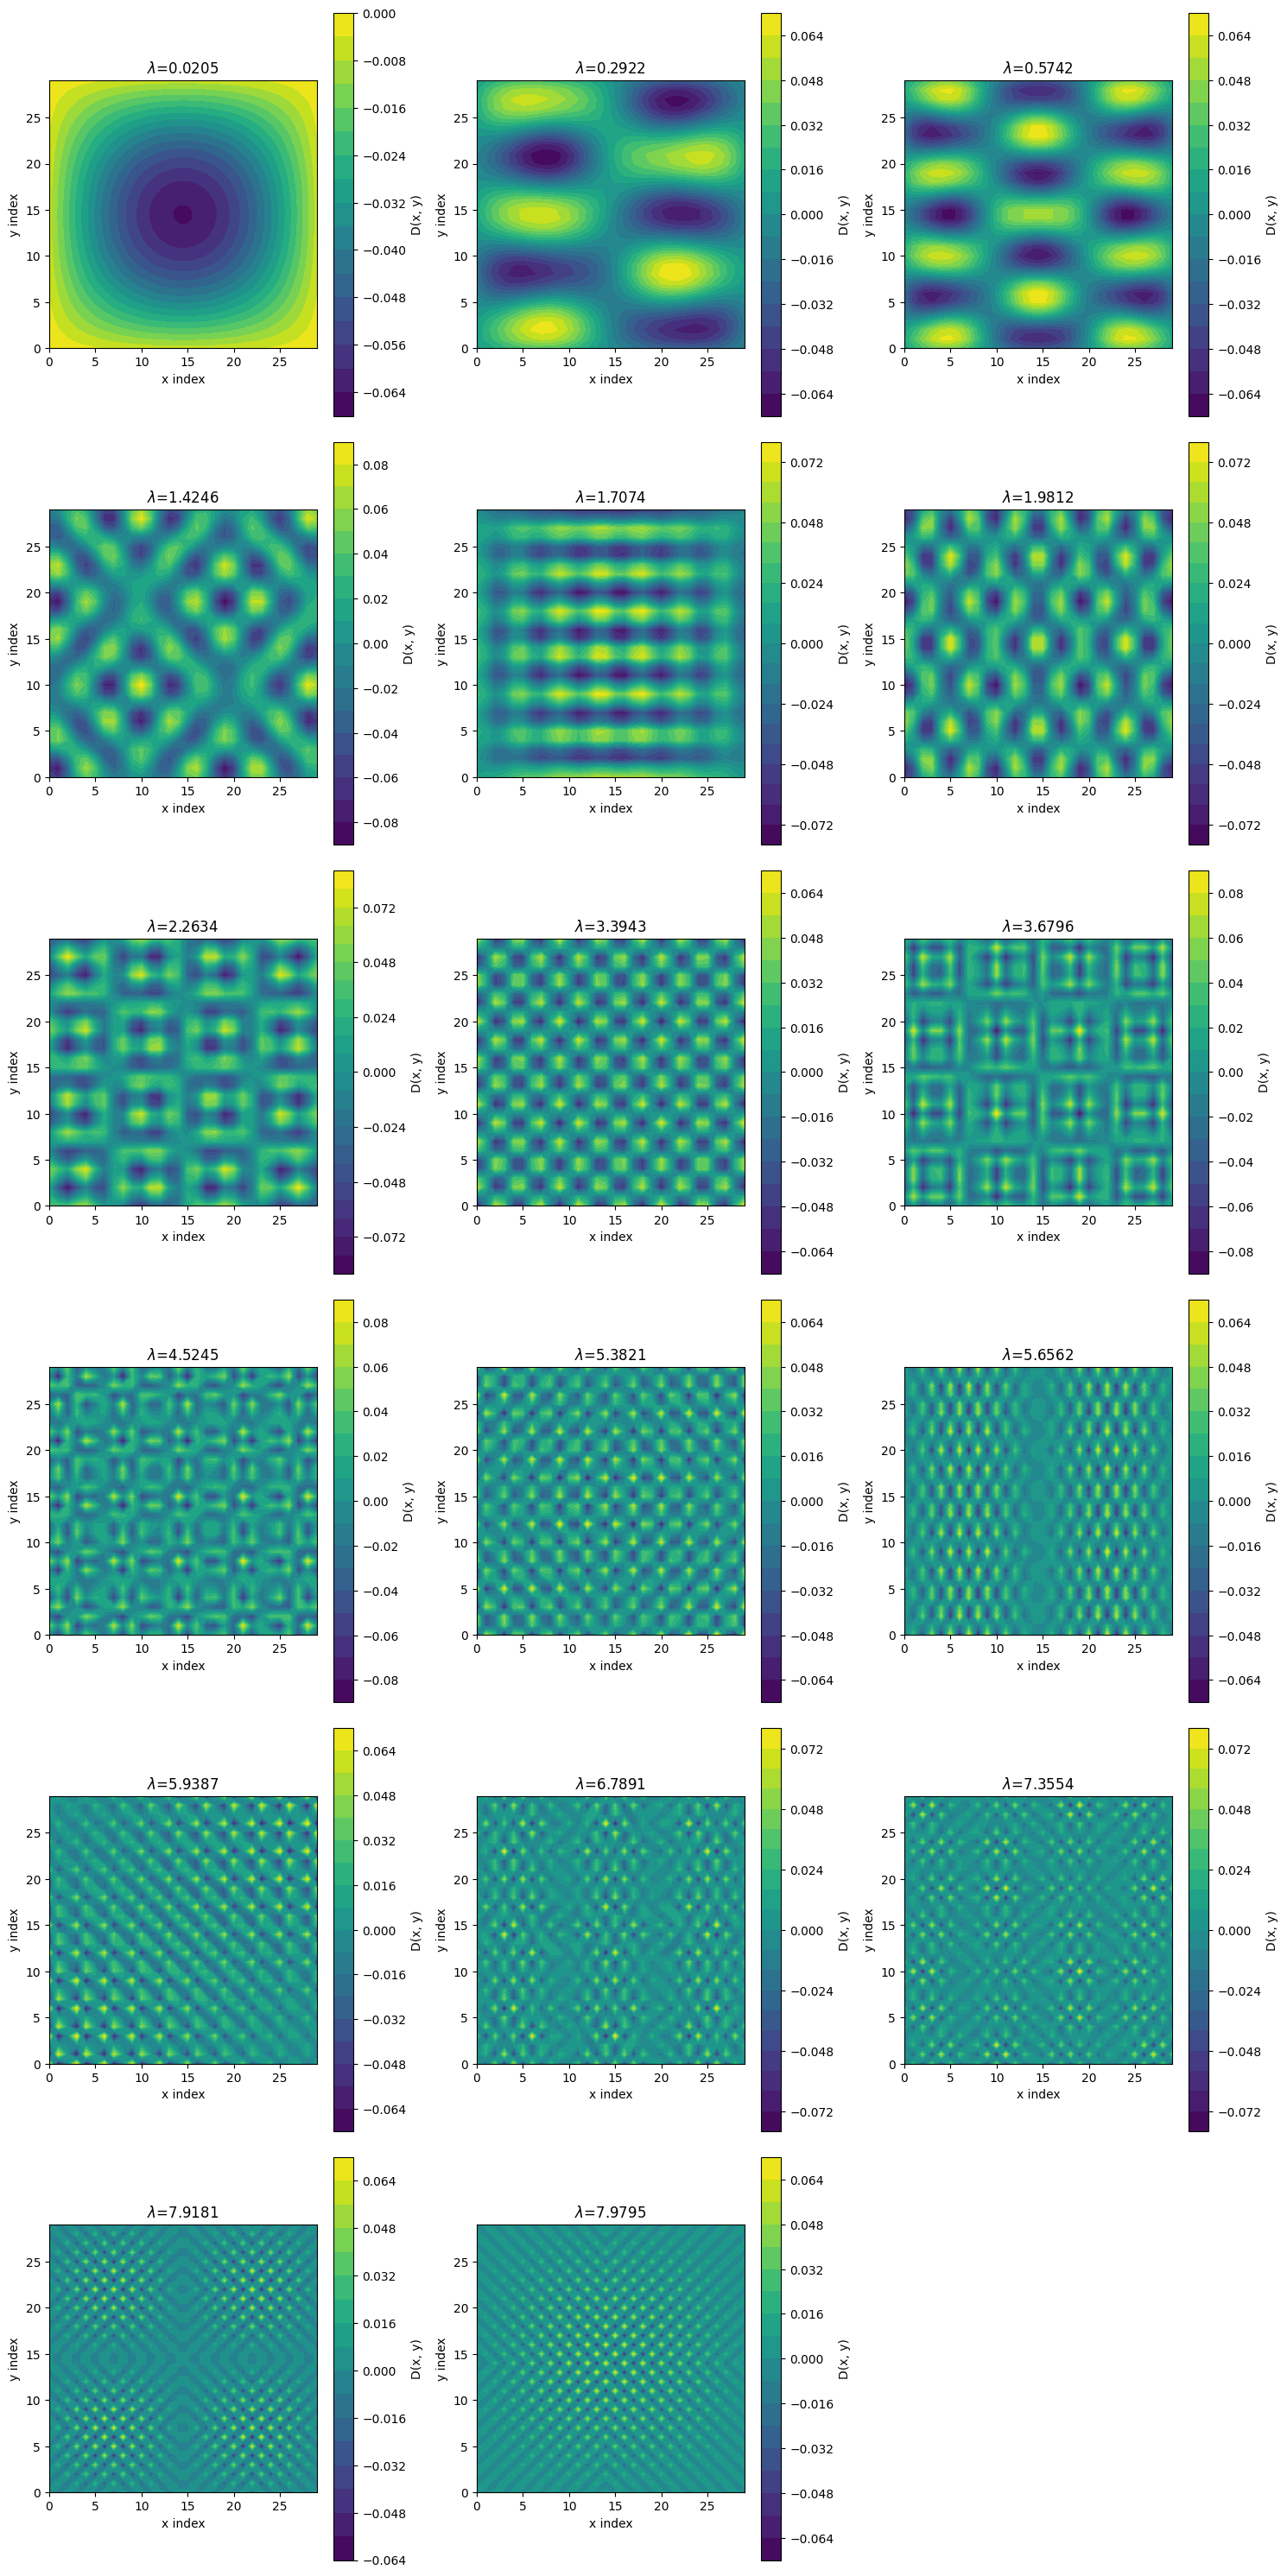

In [ ]:
def plot_chladni_figures(eig_vals, eig_vects, n_cols=3):
    """
    Trace les figures de Chladni pour les vecteurs propres donnés.

    Paramètres :
        - eig_vals  : Tableau des valeurs propres associées (numpy array)
        - eig_vects : Tableau des vecteurs propres associés (numpy array)
        - n_cols    : Nombre de colonnes de la grille de figures
    """
    print("Tracé des figures de Chladni")

    N = int(np.sqrt(len(eig_vects[0])))
    n_plots = len(eig_vals)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten() # pour pouvoir iterer sur les axes

    for i in range(n_plots):
        eig_val = eig_vals[i]
        eig_vect = eig_vects[i].reshape(N, N)
        ax = axes[i]

        contour = ax.contourf(eig_vect, levels=20, cmap='viridis')
        fig.colorbar(contour, ax=ax, label='D(x, y)')
        ax.set_title(f'$\lambda$={eig_val:.4f}')
        ax.set_xlabel('x index')
        ax.set_ylabel('y index')
        ax.set_aspect('equal', adjustable='box') # Pour avoir une grille carrée

    # On masque les axes inutiles
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Tracé des figures de Chladni
plot_chladni_figures(eig_vals, eig_vects)

## Méthode de déflation

1. En supposant que la matrice $A\in\mathbb{R}^{N\times N}$ est symétrique définie positive et que $V\in\mathbb{R}^N$ est un de ses vecteurs propres, montrer que la matrix $B_\lambda := A-\lambda V V^T$ a les mêmes vecteurs propres que $A$ pour tout $\lambda \in\mathbb{R}$.

   Soit $A$ symétrique définie positive. On peut choisir une base orthonormée de vecteurs propres $(u_1,\dots,u_N)$ telle que $u_1=\dfrac{V}{\|V\|}$ et $A u_i=\mu_i u_i$ (avec $\mu_i>0$). Alors
   $A=\sum_{i=1}^N \mu_i\,u_i u_i^T$ et $V V^T=\|V\|^2\,u_1 u_1^T$.  

   En conséquence,
   $$
   B_\lambda \;=\; A-\lambda V V^T
   \;=\; \Big(\mu_1-\lambda\|V\|^2\Big)u_1u_1^T \;+\; \sum_{i=2}^N \mu_i\,u_i u_i^T.
   $$

   On lit directement l’action de $B_\lambda$ sur la base propre de $A$ :
   $$
   B_\lambda u_1 \;=\; \big(\mu_1-\lambda\|V\|^2\big)\,u_1, \qquad
   B_\lambda u_i \;=\; \mu_i\,u_i \ \ (i\ge 2).
   $$

   Autrement dit, **tous les vecteurs propres de $A$ restent vecteurs propres de $B_\lambda$** (même base propre), et seule la valeur propre associée à $u_1$ est **décalée** de $\lambda\|V\|^2$, les autres étant **inchangées** :
   $$
   \text{spec}(B_\lambda)=\{\mu_1-\lambda\|V\|^2,\ \mu_2,\dots,\mu_N\}.
   $$

## Méthode de déflation

2. En exploitant les matrices de la forme $B_{\lambda}$, proposer une méthode pour obtenir la seconde plus grande valeur propre de $A$ et son vecteur propre associé. Puis toutes les valeurs propres.

   On commence par appliquer la **méthode de la puissance** à $A$ pour obtenir la plus grande valeur propre $\lambda_1$ et un vecteur propre unitaire $v_1$ associé ($\|v_1\|=1$). On construit alors
   $$ B_{\lambda_1} \;=\; A \;-\; \lambda_1\, v_1 v_1^{\top}. $$

   Si $(u_i)_{i=1}^N$ est une base orthonormée de vecteurs propres de $A$ avec $A u_i=\lambda_i u_i$ et $\lambda_1\ge\lambda_2\ge\cdots\ge\lambda_N$, et si $v_1=u_1$, on a
   $$ B_{\lambda_1} u_1 = (\lambda_1-\lambda_1)u_1 = 0, \qquad B_{\lambda_1} u_i = \lambda_i u_i \ \ (i\ge 2). $$
   Ainsi $B_{\lambda_1}$ possède les **mêmes vecteurs propres** que $A$ et son spectre est $\,\{0,\lambda_2,\dots,\lambda_N\}\,$ : la valeur propre dominante de $B_{\lambda_1}$ est donc $\lambda_2$ (avec vecteur propre $u_2$).

   On en déduit la procédure itérative :
   - poser $A_0 := A$ ; appliquer la puissance à $A_0$ pour obtenir $(\lambda_1,v_1)$, puis définir $$ A_1 := B_{\lambda_1} \;=\; A_0 \;-\; \lambda_1\, v_1 v_1^{\top} ; $$
   - appliquer la puissance à $A_1$ pour obtenir $(\lambda_2,v_2)$, puis définir $$ A_2 \;:=\; B_{\lambda_2} \;=\; A_1 \;-\; \lambda_2\, v_2 v_2^{\top} ; $$
   - et ainsi de suite : pour $i\ge 1$,
   
   $$ A_i := A_{i-1} - \lambda_i\, v_i v_i^{\top}.$$

   À chaque étape, la valeur propre dominante de $A_i$ est $\lambda_{i+1}$, avec vecteur propre $v_{i+1}$, ce qui permet d’extraire successivement $\lambda_2,\lambda_3,\dots$.

   **Critère d’arrêt.** On s’arrête lorsque la valeur propre dominante calculée à l’étape $i$ est **très faible** au sens d’un seuil fixé $\mathrm{TOL}>0$ :
   $ \lambda_i \;\le\; \mathrm{TOL}, $ ou lorsqu'on a atteint un seuil max d'itérations N_lambs_max.


3. Implémenter cette méthode et la tester avec la matrice du Laplacien $L\in\mathbb{R}^{N\times N}$ pour $N = 50$ avec un critère de tolérance de $10^{-6}$. Puis avec un critère de tolérance de $10^{-12}$.

4. Tester à nouveau avec la matrice du Laplacien 2D. Analyser et interpréter.

In [ ]:
def deflation(A, V, N_lambs_max=100, N_max=1000, TOL=pow(10, -6)):
    """
    Calcule plusieurs valeurs propres et vecteurs propres d'une matrice A
    en utilisant la méthode de déflation successive.

    Paramètres :
        - A             : matrice (numpy array)
        - V             : vecteur initial (numpy array)
        - N_lambs_max   : nombre maximum de valeurs propres à calculer (int)
        - N_max         : nombre maximum d'itérations pour la méthode de puissance (int)
        - TOL           : tolérance pour le critère d'arrêt (float)

    Retourne :
        - eig_vals  : Tableau des valeurs propres approchées (numpy array)
        - eig_vects : Tableau des vecteurs propres associés (numpy array)
        - errors    : Tableau des erreurs finales pour chaque valeur propre (numpy array)
    """
    N = A.shape[0]
    # Initialisation des tableaux pour stocker les résultats
    eig_vals = np.empty(N_lambs_max)
    eig_vects = np.empty((N_lambs_max, N, 1))
    errors = np.empty(N_lambs_max)

    # Calcul de la première valeur propre et du vecteur propre associé
    eig_vals[0], eig_vects[0], error = puissance(A, V, N_max=N_max, TOL=TOL)
    errors[0] = error[-1] # Stockage de l'erreur finale

    # Calculs les valeurs propres restantes par déflation
    for i in range(1, N_lambs_max):
        # Construction de la matrice déflatée
        A = A - eig_vals[i-1] * eig_vects[i-1] @ eig_vects[i-1].T
        # Application de la méthode de puissance à la matrice déflatée
        eig_vals[i], eig_vects[i], error = puissance(A, V, N_max=N_max, TOL=TOL)
        errors[i] = error[-1]

        # Critère d'arrêt basé sur la proximité de la valeur propre calculée à zéro
        if np.isclose(eig_vals[i], 0.0, atol=TOL):
            break


    return eig_vals[:i], eig_vects[:i], errors[:i]

 17%|█▋        | 171/1000 [00:00<00:00, 44286.88it/s]


 Convergence atteinte après 171 itérations


 13%|█▎        | 129/1000 [00:00<00:00, 41451.41it/s]


 Convergence atteinte après 129 itérations


  9%|▉         | 93/1000 [00:00<00:00, 42206.26it/s]


 Convergence atteinte après 93 itérations


  6%|▌         | 61/1000 [00:00<00:00, 36972.91it/s]


 Convergence atteinte après 61 itérations


  4%|▍         | 40/1000 [00:00<00:00, 31993.17it/s]


 Convergence atteinte après 40 itérations


  4%|▍         | 38/1000 [00:00<00:00, 34180.47it/s]


 Convergence atteinte après 38 itérations


  2%|▏         | 24/1000 [00:00<00:00, 31078.51it/s]


 Convergence atteinte après 24 itérations


  2%|▏         | 19/1000 [00:00<00:00, 25155.23it/s]


 Convergence atteinte après 19 itérations


  1%|          | 10/1000 [00:00<00:00, 25763.54it/s]


 Convergence atteinte après 10 itérations


  0%|          | 1/1000 [00:00<00:00, 6502.80it/s]


 Convergence atteinte après 1 itérations


  0%|          | 0/1000 [00:00<?, ?it/s]


 Convergence atteinte après 0 itérations
Valeurs propres obtenues :
 [3.91898595 3.68250707 3.30972147 2.83083003 2.28462968 1.71537032
 1.16916997 0.69027853 0.31749293 0.08101405] 

Vraies valeurs propres :
 [3.91898595 3.68250707 3.30972147 2.83083003 2.28462968 1.71537032
 1.16916997 0.69027853 0.31749293 0.08101405] 



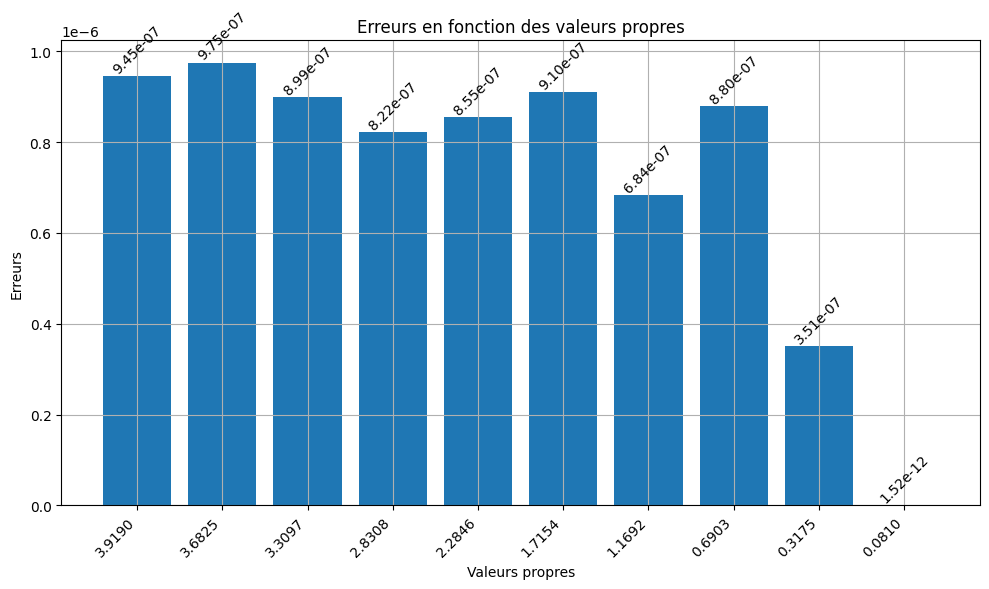

In [ ]:
# 3. Cas test trivial Laplacien 1D
eig_vals, eig_vects, errors = deflation(L, V0, N_max=1000, TOL=pow(10, -6))

print("Valeurs propres obtenues :\n", eig_vals, "\n")

print("Vraies valeurs propres :\n", lambs, "\n") # Calculées plus haut

def plot_eigenvalue_errors(eig_vals, errors):
    """
    Trace un graphique à barres des erreurs d'estimation des valeurs propres.

    Paramètres :
        - eig_vals : Tableau des valeurs propres approchées (numpy array)
        - errors   : Tableau des erreurs finales pour chaque valeur propre (numpy array)
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(eig_vals)), errors, tick_label=[f'{val:.4f}' for val in eig_vals])
    plt.xlabel("Valeurs propres")
    plt.ylabel("Erreurs")
    plt.title("Erreurs en fonction des valeurs propres")
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')

    # Affichage des erreurs sur les barres
    for i, error in enumerate(errors):
        plt.text(i, error, f'{error:.2e}', ha='center', va='bottom', rotation=45)

    plt.tight_layout()
    plt.show()

plot_eigenvalue_errors(eig_vals, errors)

 60%|█████▉    | 1194/2000 [00:01<00:00, 846.67it/s]


 Convergence atteinte après 1194 itérations


 66%|██████▋   | 1330/2000 [00:00<00:00, 2166.40it/s]


 Convergence atteinte après 1330 itérations


100%|██████████| 2000/2000 [00:02<00:00, 699.70it/s]


 Convergence non atteinte après 2000 itérations


 80%|████████  | 1604/2000 [00:00<00:00, 3178.80it/s]


 Convergence atteinte après 1604 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3179.14it/s]


 Convergence non atteinte après 2000 itérations


 55%|█████▌    | 1104/2000 [00:00<00:00, 3389.63it/s]


 Convergence atteinte après 1104 itérations


100%|██████████| 2000/2000 [00:00<00:00, 2985.15it/s]


 Convergence non atteinte après 2000 itérations


 74%|███████▍  | 1482/2000 [00:00<00:00, 3353.02it/s]


 Convergence atteinte après 1482 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3210.41it/s]


 Convergence non atteinte après 2000 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3033.73it/s]


 Convergence non atteinte après 2000 itérations


 47%|████▋     | 939/2000 [00:00<00:00, 3256.04it/s]


 Convergence atteinte après 939 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3428.11it/s]


 Convergence non atteinte après 2000 itérations


 55%|█████▍    | 1096/2000 [00:00<00:00, 3154.77it/s]


 Convergence atteinte après 1096 itérations


 82%|████████▏ | 1645/2000 [00:00<00:00, 3299.00it/s]


 Convergence atteinte après 1645 itérations


 83%|████████▎ | 1656/2000 [00:00<00:00, 3115.91it/s]


 Convergence atteinte après 1656 itérations


 49%|████▉     | 975/2000 [00:00<00:00, 3299.58it/s]


 Convergence atteinte après 975 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3045.96it/s]


 Convergence non atteinte après 2000 itérations


 71%|███████▏  | 1427/2000 [00:00<00:00, 3301.33it/s]


 Convergence atteinte après 1427 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3134.31it/s]


 Convergence non atteinte après 2000 itérations


 63%|██████▎   | 1268/2000 [00:00<00:00, 3372.65it/s]


 Convergence atteinte après 1268 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3125.03it/s]


 Convergence non atteinte après 2000 itérations


 64%|██████▍   | 1277/2000 [00:00<00:00, 3284.84it/s]


 Convergence atteinte après 1277 itérations


100%|██████████| 2000/2000 [00:02<00:00, 876.51it/s]


 Convergence non atteinte après 2000 itérations


100%|██████████| 2000/2000 [00:01<00:00, 1403.98it/s]


 Convergence non atteinte après 2000 itérations


 65%|██████▍   | 1297/2000 [00:00<00:00, 3303.77it/s]


 Convergence atteinte après 1297 itérations


 84%|████████▎ | 1671/2000 [00:00<00:00, 3139.88it/s]


 Convergence atteinte après 1671 itérations


 50%|████▉     | 998/2000 [00:00<00:00, 3356.48it/s]


 Convergence atteinte après 998 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3221.73it/s]


 Convergence non atteinte après 2000 itérations


100%|██████████| 2000/2000 [00:00<00:00, 3194.87it/s]


 Convergence non atteinte après 2000 itérations


 48%|████▊     | 955/2000 [00:00<00:00, 2599.33it/s]


 Convergence atteinte après 955 itérations
Valeurs propres obtenues :
 [7.97947697 7.94879853 7.91811776 7.89801916 7.94872202 7.86741459
 7.82765257 7.89801704 7.81654594 7.86733825 7.79698861 7.74565396
 7.82765291 7.73897303 7.7969754  7.70775333 7.67566619 7.746194
 7.73843169 7.65713676 7.70774971 7.63126902 7.60023235 7.65601974
 7.58791066 7.63126541 7.54980555 7.57046056 7.58360931] 

Tracé des figures de Chladni


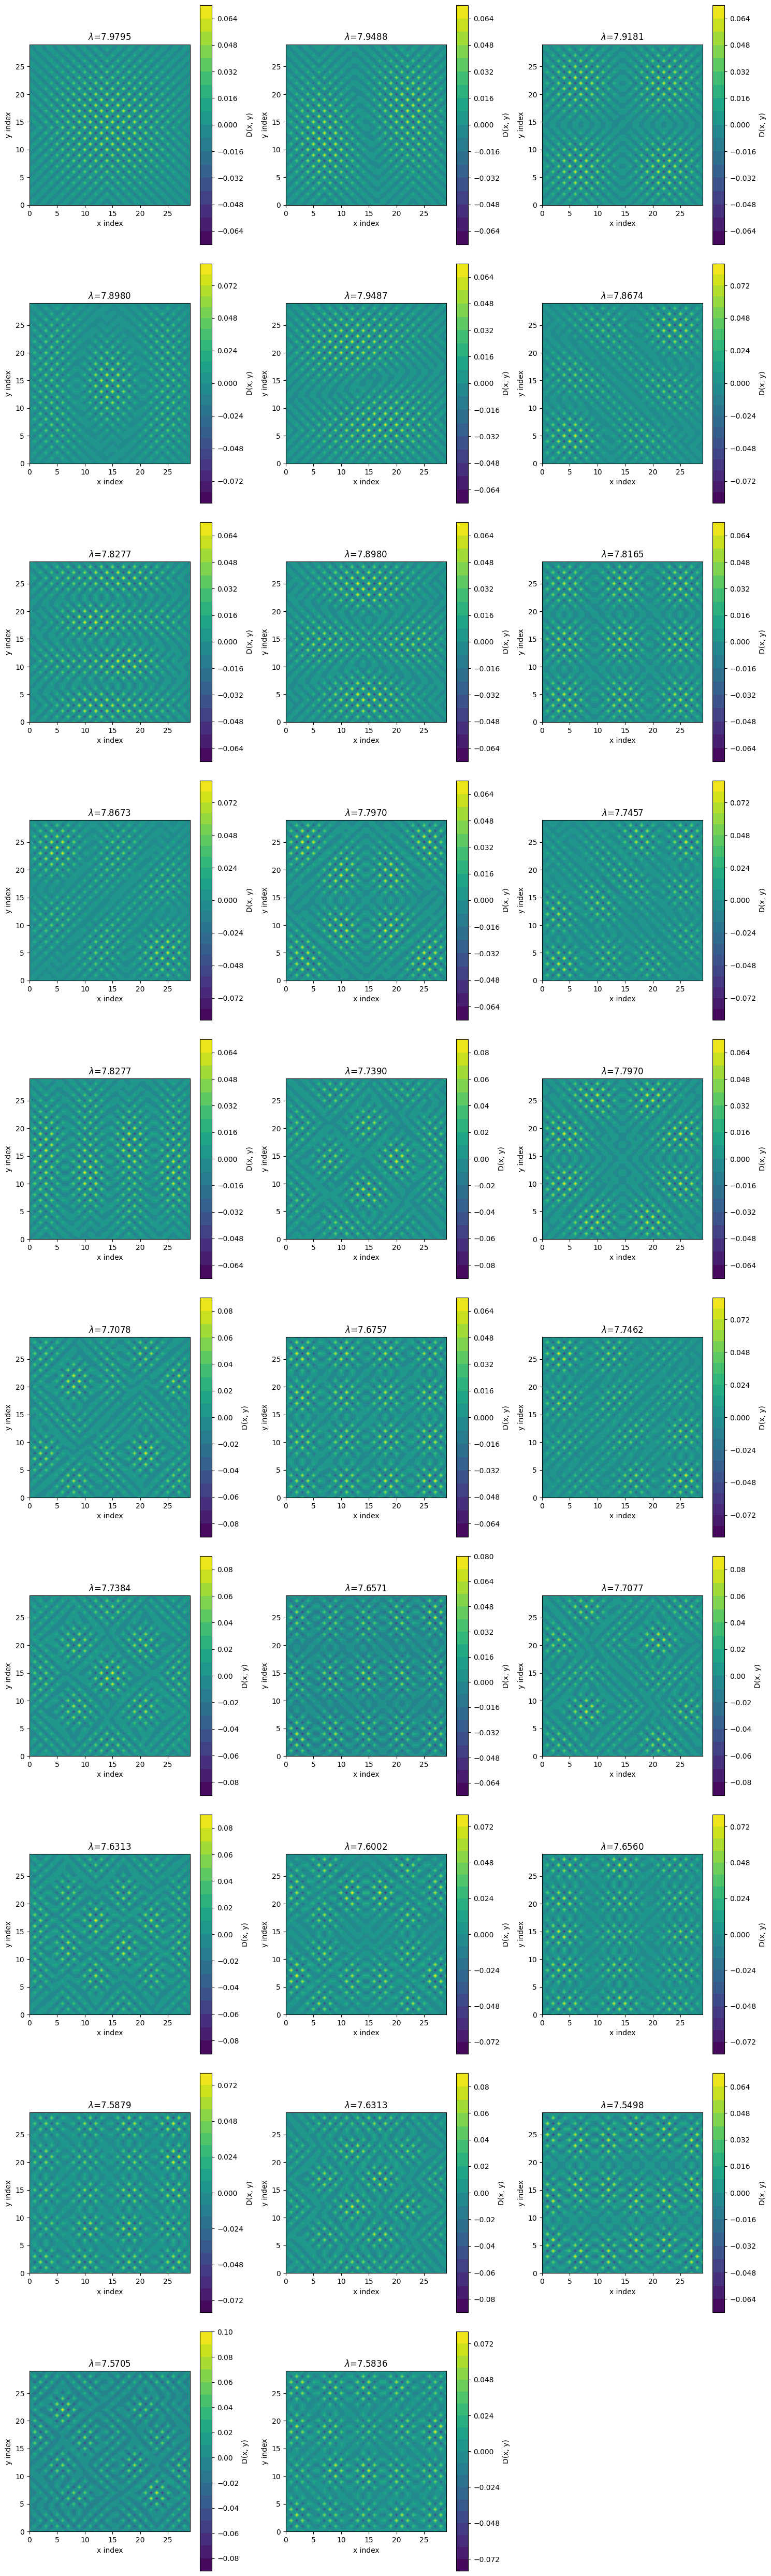

In [ ]:
# 4. Cas test du Laplacien 2D

eig_vals2, eig_vects2, errors2 = deflation(L2, D0_vect, N_lambs_max=30, N_max=2000, TOL=pow(10, -4))

print("Valeurs propres obtenues :\n", eig_vals2, "\n")

plot_chladni_figures(eig_vals2, eig_vects2)

**Observations:**

- Avec la méthode de la déflation, on obtient les valeurs propres dans l'ordre décroissant.

- Il n'y a que la 1ère valeur propre qui prend du temps à être trouvée ; une fois trouvée, le calcul des autres est bien plus rapide

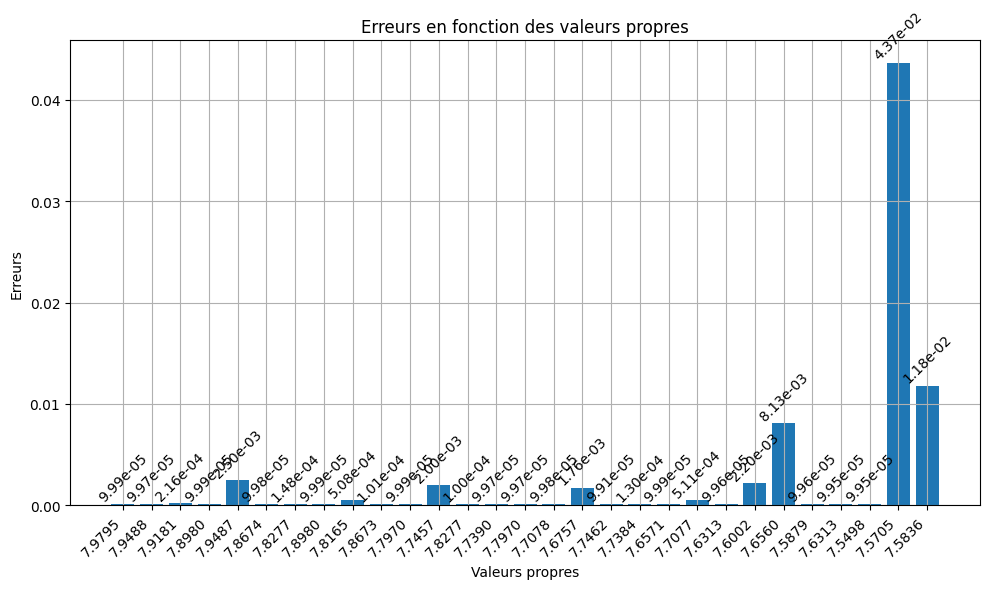

In [ ]:
# Tracé des erreurs en fonction des valeurs propres
plot_eigenvalue_errors(eig_vals2, errors2)


# Pour aller plus loin

## Autour du Laplacien

Tester à nouveau votre algorithme en modifiant le problème à résoudre :
- en ajoutant des obstacles (bord à l'intérieur du domaine) dans le domaine
- en modifiant la forme du domaine spatial
- en modifiant les conditions de bord avec des conditions de type Neumann ou Robin

## Autour de la résolution du problème aux valeurs propres

Une des principales alternatives à la méthode de la puissances est la méthode QR. Cette méthode est donnée par l'algorithme suivant :
1. Initialiser $A^0 = A$
2. Itérer jusqu'à convergence :
- décomposer la matrice $A^i = Q^iR^i$ comme le produit d'une matrice orthogonal $Q^i$ et d'une matrice triangulaire supérieur $R^i$
- calculer $A^{i+1} = R^i Q^i$

Pour aller plus loin, vous pouvez
- coder cette méthode et comparer ses performances avec la méthode de la puissance (on pourra utiliser la dacomposition *qr* de numpy.linalg).
- analyser l'algorithme pour relier sa convergence à celle de la méthode de la puissance

In [ ]:
def qr_method(A, N_max=1000, TOL=pow(10, -12)):
    """
    Renvoie les valeurs propres approchées de A par la méthode QR
    ----------
    Paramètres :
        - A     : matrice
        - N_max : nombre maximum d'itérations
        - TOL   : tolérance pour le critère d'arrêt

    Retourne :
        - eig_vals  : Tableau des valeurs propres approchées (numpy array)
        - approx_lamb1 : Tableau des approximations de la 1ere valeur propre durant les itérations ; sera utile pour estimer l'évolution de la convergence pour la 1ere valeur propre
    """
    A_k = A
    approx_lamb1 = np.empty(N_max) # Stocke les approximations de la 1ere valeur propre durant les itérations

    for k in tqdm(range(N_max)):
        Q, R = qr(A_k)
        A_k = R @ Q

        # Les valeurs propres sont sur la diagonale de A_k
        approx_lamb1[k] = np.diag(A_k)[0] # Stockage de l'approximation de la 1ere valeur propre à l'itération k

        # Critère d'arrêt (basé sur la convergence de la diagonale)
        if k > 0 and np.linalg.norm(np.diag(A_k) - np.diag(A_k_prev)) < TOL:
             print(" Convergence atteinte après {} itérations".format(k))
             return np.diag(A_k), approx_lamb1[:k+1]

        A_k_prev = A_k


    print(" Convergence non atteinte après {} itérations".format(N_max))
    return np.diag(A_k), eig_vals

In [ ]:
# Test de la méthode QR avec le Laplacian (N=10)

eig_vals_qr, approx_lamb1 = qr_method(L, N_max=1000, TOL=pow(10, -12))

print("Valeurs propres obtenues par la méthode QR:", eig_vals_qr)

 21%|██        | 207/1000 [00:00<00:00, 8876.15it/s]

 Convergence atteinte après 207 itérations
Valeurs propres obtenues par la méthode QR: [3.91898595 3.68250707 3.30972147 2.83083003 2.28462968 1.71537032
 1.16916997 0.69027853 0.31749293 0.08101405]


/tmp/ipython-input-1508132919.py:5: RuntimeWarning: divide by zero encountered in log
  errors_log_qr = np.log(np.abs(approx_lamb1 - eig_vals_qr[0]))


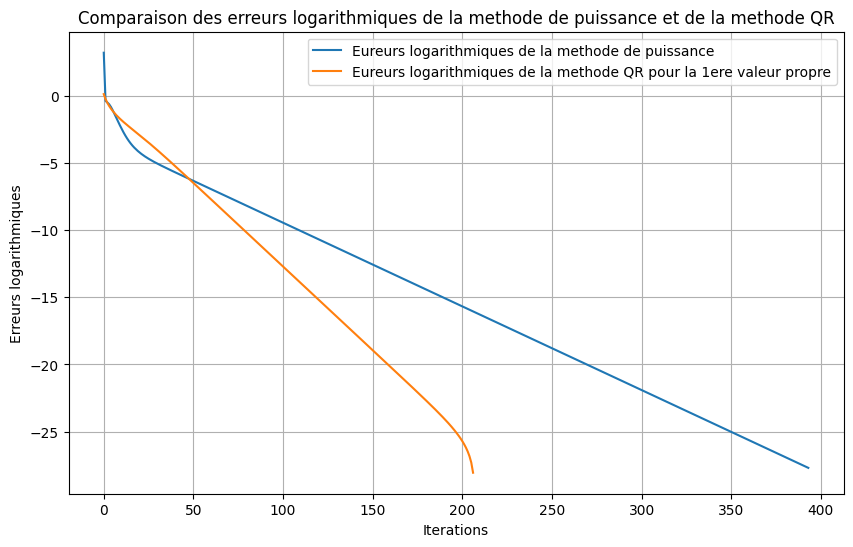

In [ ]:
# Comparaison de la convergence de la methode QR et de la methode de puissance

# Recuperation des erreurs de la methode de puissance evaluées au début
errors_log_power = errors_log
errors_log_qr = np.log(np.abs(approx_lamb1 - eig_vals_qr[0]))

plt.figure(figsize=(10, 6))
plt.plot(errors_log_power, label="Eureurs logarithmiques de la methode de puissance")
plt.plot(errors_log_qr, label="Eureurs logarithmiques de la methode QR pour la 1ere valeur propre")
plt.xlabel("Iterations")
plt.ylabel("Erreurs logarithmiques")
plt.title("Comparaison des erreurs logarithmiques de la methode de puissance et de la methode QR")
plt.legend()
plt.grid(True)
plt.show()

**Analyse de la convergence** :

La méthode QR converge vers toutes les valeurs propres simultanément, tandis que la méthode de puissance converge vers la plus grande valeur propre. Le taux de convergence de la méthode de puissance dépend du rapport entre la plus grande et la deuxième plus grande valeur propre. La convergence de la méthode QR est généralement plus rapide que la méthode de puissance pour trouver toutes les valeurs propres.